In [1]:
import SimpleITK as sitk
from pathlib import Path
import pydicom
import numpy as np
import pandas as pd
from tempfile import TemporaryDirectory
import nrrd
import slicerio
from datetime import datetime
from suv import (
    starguide_convert_counts_to_bqml,
    getAcquisitionDateTime,
    BAMF_STARGUIDE_SENSITIVITY,
)
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# read dicom series with SimpleITK
def sitkReader(series_dir: Path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(str(series_dir))
    reader.SetFileNames(dicom_names)
    return reader.Execute()

To convert a Starguide image from counts to quantitative activity, you need the acquisition duration from `ImageComments` dicom tag (which is in ms), and the sensitivity conversion factor, which is specific to each Starguide scanner and energy window.

| Variable | Symbol | units |
| --- | --- | --- |
| Camera Sensitivity | S | (cnt/min/µCi) |
| Voxel counts | C | cnt |
| Scan Duration | T | min |
| Voxel Size | V | ml |
| Voxel Activity | Y | µCi/ml |

Y = C / (S * T * V)

In [3]:
# Converts Starguide counts image to quantitative image
def convert_to_bqml(spect_img: sitk.Image, series_dcm_dir: Path):
    spect_ds = pydicom.dcmread(next(series_dcm_dir.glob("*.dcm")))

    # multiframe dicom images get loaded as 4D, squeeze to 3D
    if spect_img.GetDimension() == 4 and spect_img.GetSize()[3] == 1:
        spect_img = spect_img[..., 0]

    spect_bqml = starguide_convert_counts_to_bqml(
        spect_img, spect_ds, camera_sensitivity=BAMF_STARGUIDE_SENSITIVITY.combo
    )
    return spect_bqml

In [4]:
class StarGuideTimepoint:
    def __init__(
        self, spect_dcm_folder: Path, ct_dcm_folder: Path, seg_file: Path
    ) -> None:
        self.ct_img = sitkReader(ct_dcm_folder)
        self.aquisition_time = getAcquisitionDateTime(
            pydicom.dcmread(next(spect_dcm_folder.glob("*.dcm")))
        )
        self.spect_img = sitkReader(spect_dcm_folder)
        self.spect_bqml = convert_to_bqml(self.spect_img, spect_dcm_folder)

        # parse segmentation, one mask per segment. This handles overlaping segments
        self.seg_img = sitk.ReadImage(str(seg_file))
        segmentation_info = slicerio.read_segmentation_info(str(seg_file))
        voxels, header = nrrd.read(seg_file)
        self._segments = {}
        for segment in segmentation_info["segments"]:
            name = segment["name"]
            assert name not in self._segments, f"Segment {name} already exists"
            extracted_voxels, extracted_header = slicerio.extract_segments(
                voxels, header, segmentation_info, [(name, 1)]
            )
            with TemporaryDirectory() as tmpdir:
                tmpfile = Path(tmpdir) / "tmp.nrrd"
                nrrd.write(str(tmpfile), extracted_voxels, extracted_header)
                tmp_img = sitk.ReadImage(str(tmpfile), sitk.sitkUInt8)
                self._segments[name] = tmp_img

    @property
    def segment_names(self):
        return list(self._segments.keys())

    def segment_vol(self, name):
        mask_img = self._segments[name]
        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(self.spect_bqml)
        resampler.SetInterpolator(sitk.sitkNearestNeighbor)
        resampler.SetDefaultPixelValue(0)
        mask_img = resampler.Execute(mask_img)

        stats = sitk.LabelStatisticsImageFilter()
        stats.Execute(self.spect_bqml, mask_img)
        pixel_ml = np.prod(mask_img.GetSpacing()) / 1000
        seg_ml = stats.GetCount(1) * pixel_ml
        return seg_ml

    def segment_bq(self, name):
        mask_img = self._segments[name]
        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(self.spect_bqml)
        resampler.SetInterpolator(sitk.sitkNearestNeighbor)
        resampler.SetDefaultPixelValue(0)
        mask_img = resampler.Execute(mask_img)

        stats = sitk.LabelStatisticsImageFilter()
        stats.Execute(self.spect_bqml, mask_img)
        pixel_ml = np.prod(mask_img.GetSpacing()) / 1000
        seg_bq = stats.GetSum(1) * pixel_ml
        return seg_bq

    def ideal_segment_bq(
        self,
        name,
        initial_activity_bqml: float,
        initial_time: datetime,
        halflife_s: float,
    ):
        initial_segment_bq = initial_activity_bqml * self.segment_vol(name)
        ideal_segment_bq = initial_segment_bq * (0.5) ** (
            (self.aquisition_time - initial_time).total_seconds() / (halflife_s)
        )
        return ideal_segment_bq

In [5]:
# Phantom activity information
# the time portion is an estimate, i don't know exactly when the dose was assayed
injection_time = datetime(2023, 6, 1, 12, 0, 0)
injection_dose = 67.5 * 37000000  # 67.5 mCi in Bq
phantom_volume_ml = 5667  # estimated volume from water label segmentation of phantom
halflife = 574300.8  # seconds, Lu177 radioisotope

In [7]:
data_dir = Path("data")

# 10 minute acquisition time
tp0hr_10min = StarGuideTimepoint(
    data_dir / "dcm" / "0Hr - 10 min SPECT",
    data_dir / "dcm" / "0Hr - CT",
    data_dir / "0Hr.seg.nrrd",
)
tp24hr_10min = StarGuideTimepoint(
    data_dir / "dcm" / "24Hr - 10 min SPECT",
    data_dir / "dcm" / "24Hr - CT",
    data_dir / "24Hr.seg.nrrd",
)
tp96hr_10min = StarGuideTimepoint(
    data_dir / "dcm" / "96Hr - 10 min SPECT",
    data_dir / "dcm" / "96Hr - CT",
    data_dir / "96Hr.seg.nrrd",
)

# 3 minute acquisition time
tp0hr_3min = StarGuideTimepoint(
    data_dir / "dcm" / "0Hr - 3 min SPECT",
    data_dir / "dcm" / "0Hr - CT",
    data_dir / "0Hr.seg.nrrd",
)
tp24hr_3min = StarGuideTimepoint(
    data_dir / "dcm" / "24Hr - 3 min SPECT",
    data_dir / "dcm" / "24Hr - CT",
    data_dir / "24Hr.seg.nrrd",
)
tp96hr_3min = StarGuideTimepoint(
    data_dir / "dcm" / "96Hr - 3 min SPECT",
    data_dir / "dcm" / "96Hr - CT",
    data_dir / "96Hr.seg.nrrd",
)

In [8]:
records = []

# 10 minute acquisition time
for tp in [tp0hr_10min, tp24hr_10min, tp96hr_10min]:
    for seg_name in tp.segment_names:
        records.append(
            dict(
                Acquisition=tp.aquisition_time,
                Segment=seg_name,
                Bq=tp.segment_bq(seg_name),
                # full segment is all the phantom, not just the water, however only the water is radioactive, so change the ideal_Bq to reflect that
                ideal_Bq=tp.ideal_segment_bq(
                    "water" if seg_name == "full" else seg_name,
                    injection_dose / phantom_volume_ml,
                    injection_time,
                    halflife,
                ),
                duration=10,
            )
        )


# 3 minute acquisition time
for tp in [tp0hr_3min, tp24hr_3min, tp96hr_3min]:
    for seg_name in tp.segment_names:
        records.append(
            dict(
                Acquisition=tp.aquisition_time,
                Segment=seg_name,
                Bq=tp.segment_bq(seg_name),
                # full segment is all the phantom, not just the water, however only the water is radioactive, so change the ideal_Bq to reflect that
                ideal_Bq=tp.ideal_segment_bq(
                    "water" if seg_name == "full" else seg_name,
                    injection_dose / phantom_volume_ml,
                    injection_time,
                    halflife,
                ),
                duration=3,
            )
        )

df = pd.DataFrame.from_records(records)

In [9]:
df

,Acquisition,Segment,Bq,ideal_Bq,duration
0,2023-06-01 15:02:35,full,2.388536e+09,2.464639e+09,10
1,2023-06-01 15:02:35,small,5.213215e+07,5.401452e+07,10
2,2023-06-01 15:02:35,water,2.073204e+09,2.464639e+09,10
3,2023-06-02 11:54:24,full,2.191292e+09,2.181552e+09,10
4,2023-06-02 11:54:24,small,4.828828e+07,4.950164e+07,10
5,2023-06-02 11:54:24,water,1.818634e+09,2.181552e+09,10
6,2023-06-05 08:17:16,full,1.621368e+09,1.672431e+09,10
7,2023-06-05 08:17:16,small,3.447593e+07,3.665265e+07,10
8,2023-06-05 08:17:16,water,1.394215e+09,1.672431e+09,10
9,2023-06-01 14:35:03,full,2.425256e+09,2.469558e+09,3


<Axes: xlabel='Acquisition', ylabel='Bq'>

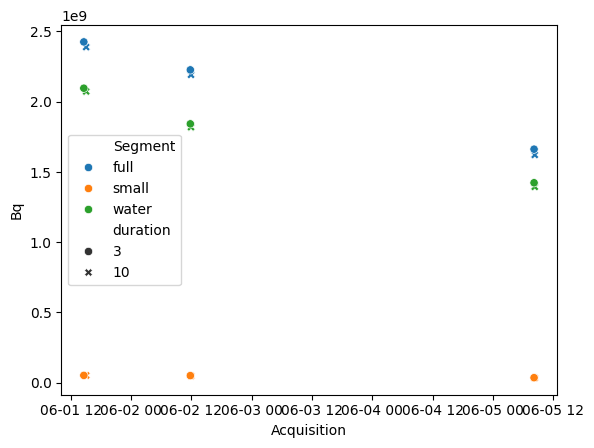

In [10]:
sns.scatterplot(data=df, x="Acquisition", y="Bq", hue="Segment", style="duration")